## Training

based on https://github.com/ShinyQ/Thesis_University-Feedback-Sentiment-Model_IndoBERT/blob/main/IndoBERT%20Classification%20Training.ipynb

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
#from datasets import load_metric

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

c:\Users\Revalda Putawara\.conda\envs\mbgsentiment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv(r"dataset/processed/processed_data_sentiment.csv")
df = df[['text_cleaned_stemmed', 'mdhugol_sentiment']]
df.rename(columns={"text_cleaned_stemmed": "text", "mdhugol_sentiment": "label"}, inplace=True)

In [5]:
df = df[['text', 'label']]
df.sample(5)

,text,label
3720,semua pihak dapat untung dari makanbergizigrat...,positive
2442,ada kait nya dengan mbgsegala cara di laku kal...,negative
2077,mitra mbg dan umkm bukti nyata bahwa sinergi i...,positive
1098,bayar program makanbergizigratis,neutral
2818,jumlah sd di sumenep 636 smp adalah 74 lembaga...,neutral


In [4]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df['text'])
plt.show()

KeyboardInterrupt: 

In [6]:
df["label"] = df["label"].map({"negative": 0, "neutral": 1, "positive": 2})

In [7]:
RANDOM_SEED = 241

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.1,
    random_state=RANDOM_SEED,
)

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_train['label'])
plt.show()

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_val['label'])
plt.show()

In [ ]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_test['label'])
plt.show()

In [8]:
print(f'Total Train: {len(df_train)}')
print(f'Total Val  : {len(df_val)}')
print(f'Total Test : {len(df_test)}')

Total Train: 3773
Total Val  : 849
Total Test : 95


In [9]:
actual_label = df_test['label']

In [10]:
df_train.to_csv(r"dataset/train/train.csv", index=False)
df_val.to_csv(r"dataset/train/eval.csv", index=False)
df_test.to_csv(r"dataset/train/test.csv", index=False)

In [11]:
from datasets import load_dataset

files = {
    "train": r"dataset/train/train.csv", 
    "eval": r"dataset/train/eval.csv", 
    "test": r"dataset/train/test.csv",
}

dataset = load_dataset('csv', data_files=files)

Generating train split: 3773 examples [00:00, 109617.22 examples/s]
Generating eval split: 849 examples [00:00, 52985.02 examples/s]
Generating test split: 95 examples [00:00, 12003.58 examples/s]


## Tokenize Model

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

In [13]:
df.head()

,text,label
0,ketua umum pdip megawati soekarnoputri sempat ...,1
1,hold wowo dapat airdrop makansianggratis,2
2,kalau mbg nya ini gue juga mau dut biar gue mu...,0
3,program mbg tuh b nya syukur bukan gizi,0
4,enggak semua anak indonesia bisa makan siang i...,0


In [15]:
def tokenize_function(text):
    return tokenizer(text["text"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3773 [00:00<?, ? examples/s]

Map: 100%|██████████| 95/95 [00:00<00:00, 2297.71 examples/s]


In [16]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

## Train Model

In [17]:
import torch
torch.cuda.empty_cache()

In [18]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [19]:
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import TrainingArguments

In [21]:
training_args = TrainingArguments(
    "test_trainer", 
    per_device_train_batch_size=4,
)

In [22]:
import evaluate

In [23]:
accuracy = evaluate.load("accuracy")

In [24]:
#metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return accuracy.compute(predictions=predictions, references=labels)


In [33]:
f1_metric = evaluate.load("f1")

def compute_f1(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return f1_metric.compute(predictions=predictions, references=labels)


In [25]:
eval_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 849
})

In [26]:
torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

training_history = trainer.train()

Step,Training Loss
500,0.849100
1000,0.706000
1500,0.565500
2000,0.468100
2500,0.273400


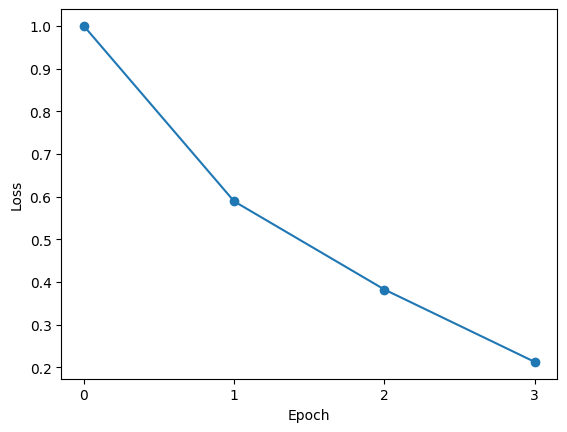

In [27]:
plt.plot([1, 0.5891, 0.3825, 0.2129], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0, 1, 2, 3])
plt.show()

In [28]:
evaluation_history = trainer.evaluate()
evaluation_history

{'eval_loss': 0.8551441431045532,
 'eval_accuracy': 0.833922261484099,
 'eval_runtime': 34.6995,
 'eval_samples_per_second': 24.467,
 'eval_steps_per_second': 3.084,
 'epoch': 3.0}

In [29]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

In [30]:
print(classification_report(prediction, actual_label, target_names=["Negatif", "Netral", "Positif"]))

              precision    recall  f1-score   support

     Negatif       0.93      0.89      0.91        44
      Netral       0.68      0.74      0.71        23
     Positif       0.86      0.86      0.86        28

    accuracy                           0.84        95
   macro avg       0.82      0.83      0.82        95
weighted avg       0.85      0.84      0.84        95



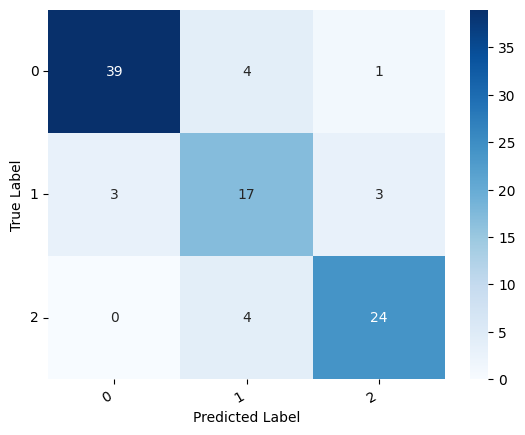

In [31]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

In [32]:
model.save_pretrained("model")

In [ ]:
f1_metric.compute(predictions=predictions, references=labels)